In [1]:
import pandas as pd
import seaborn as sb
import numpy as np

In [2]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt

import os
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,ComplementNB,BernoulliNB
import emoji
import re
from collections import Counter
from sklearn.datasets import make_classification

from imblearn.under_sampling import RandomUnderSampler
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

from nltk import FreqDist
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from keras.utils import to_categorical



Using TensorFlow backend.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nikhiloswal/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import os
import time
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
import gc
import matplotlib.pyplot as plt

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, CuDNNGRU, Conv1D, CuDNNLSTM, concatenate
from keras.layers import Bidirectional, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [4]:
train_data = pd.read_csv('./datasets/training-v1/offenseval-training-v1.tsv' , sep='\t')
train_data.drop(['id'], axis=1, inplace = True)

In [5]:
trial_data = pd.read_csv('./datasets/training-v1/offenseval-trial.tsv' , names=['tweet','subtask_a','subtask_b','subtask_c' ], sep='\t')

In [6]:
train_data = pd.concat([trial_data, train_data], ignore_index=True)

In [7]:
train_data.shape

(13560, 4)

## Exploratory Data Analysis

In [8]:
train_data.head()

,tweet,subtask_a,subtask_b,subtask_c
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN


In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13560 entries, 0 to 13559
Data columns (total 4 columns):
tweet        13560 non-null object
subtask_a    13560 non-null object
subtask_b    4477 non-null object
subtask_c    3915 non-null object
dtypes: object(4)
memory usage: 423.8+ KB


In [10]:
train_data = train_data[train_data.subtask_c != 'ORG']

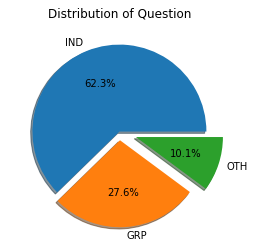

In [11]:
ax=train_data['subtask_c'].value_counts().plot.pie(explode=[0,0.1,0.2],autopct='%1.1f%%' ,shadow=True)
ax.set_title('Distribution of Tweets')
ax.set_ylabel('')
plt.show()

Individual:  2437
Group :  1078
Other :  397


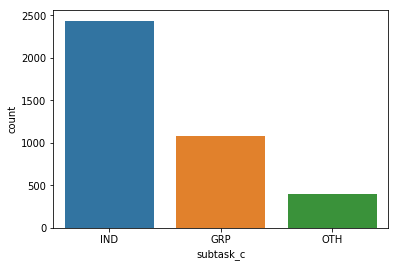

In [12]:
plot_sb = sb.countplot(train_data['subtask_c'], label='Total')
IND, GRP ,OTH  = train_data['subtask_c'].value_counts()
print('Individual: ',IND)
print('Group : ',GRP)
print('Other : ',OTH)

## Preprocessing Dataset

In [13]:
def handle_emoji(text):
    # Dictionnary of "important" emojis : 
    emoji_dict =  {'♥️': ' love ',
                   '❤️' : ' love ',
                   '❤' : ' love ',
                   '😘' : ' kisses ',
                  '😭' : ' cry ',
                  '💪' : ' strong ',
                  '🌍' : ' earth ',
                  '💰' : ' money ',
                  '👍' : ' ok ',
                   '👌' : ' ok ',
                  '😡' : ' angry ',
                  '🍆' : ' dick ',
                  '🤣' : ' haha ',
                  '😂' : ' haha ',
                  '🖕' : ' fuck you '}

    for cha in emoji_dict:
        text = re.compile(str(cha)).sub(str(emoji_dict[cha]),text)
    # Remove ALL emojis
    text = emoji.get_emoji_regexp().sub(r' ',text) 
    text = re.compile("([\U0001f3fb-\U0001f3ff])").sub(r'',text) 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r'',text) 
    text = re.compile("(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff])").sub(r'',text)

    # Add Space between  the Emoji Expressions : 
    text = re.compile("([\U00010000-\U0010ffff])").sub(r' \1 ',text) 
    return text


In [14]:
def clean_tweet(text):
    ''' Function that is applied to every to tweet in the dataset '''

    # =========== TEXT ===========
    # Replace @USER by <user>
    text = re.compile(r'@USER').sub(r'<user>',text)

    # Replace URL by <url>
    text = re.compile(r'URL').sub(r'<url>',text)

    # Remove numbers :
    text = re.compile(r'[0-9]+').sub(r' ',text)

    # Remove some special characters
    text = re.compile(r'([\xa0_\{\}\[\]¬•$,:;/@#|\^*%().~`”"“-])').sub(r' ',text) 

    # Space the special characters with white spaces
    text = re.compile(r'([$&+,:;=?@#|\'.^*()%!"’“-])').sub(r' \1 ',text)

    # Replace some special characters : 
    replace_dict = {r'&' : 'and' , r'&amp;' : 'and' , 
                    r'\+' : 'plus'}
    for cha in replace_dict:
        text = re.compile(str(cha)).sub(str(replace_dict[cha]),text)

    # Handle Emoji : translate some and delete the others
    text = handle_emoji(text)

    # Word delengthening : 
    text = re.compile(r'(.)\1{3,}').sub(r'\1\1',text)

    # Cut the words with caps in them : 
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)
    text = re.compile(r'([a-z]+|[A-Z]+|[A-Z][a-z]+)([A-Z][a-z]+)').sub(r'\1 \2',text)        
    # =========== TOKENS ===========
    # TOKENIZE 
    text = text.split(' ')

    # Remove white spaces tokens
    text = [text[i] for i in range(len(text)) if text[i] != ' ']

    # Remove empty tokens
    text = [text[i] for i in range(len(text)) if text[i] != '']

    # Remove repetition in tokens (!!! => !)
    text = [text[i] for i in range(len(text)) if text[i] != text[i-1]]

    #  Handle the ALL CAPS Tweets 
    ### if ratio of caps in the word > 75% add allcaps tag <allcaps>
    caps_r = np.mean([text[i].isupper() for i in range(len(text))])
    if caps_r > 0.6 : 
        text.append('<allcaps>')

    # Lower Case : 
    text = [text[i].lower() for i in range(len(text))]
    
    return " ".join(str(x) for x in text)

In [15]:
train_data['subtask_c'].replace({'IND':0, 'GRP': 1, 'OTH': 2}, inplace= True)

In [16]:
train_data["preprocessed_tweet"] = train_data["tweet"].apply(clean_tweet)

In [17]:
train_data.head()

,tweet,subtask_a,subtask_b,subtask_c,preprocessed_tweet
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN,breitbart news ok shannon you tell the veteran...
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN,lefty glenn jaredeker book universe hashtagzem...
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN,hot mom sucks off step son in shower min https...
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN,bro these are some cute butt plugs i m trying ...
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN,arizona supreme court strikes down state legis...


In [18]:
train_data = train_data.dropna(subset=['subtask_c'])

In [19]:
train_data.shape

(3912, 5)

## Feature Extraction

In [20]:
X = train_data["preprocessed_tweet"].values
y = train_data["subtask_c"].values

In [21]:
y = to_categorical(y)

In [100]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, stratify=y, test_size=0.25)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, stratify=train_y, test_size=0.1)

In [101]:
print("Train shape : ",train_X.shape)
print("Validation shape : ",val_X.shape)
print("Test shape : ",test_X.shape)


Train shape :  (2640,)
Validation shape :  (294,)
Test shape :  (978,)


In [102]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.00e+00 5.28e+03]
 [1.00e+00 2.64e+03]]
[[  0. 588.]
 [  1. 294.]]
[[0.000e+00 1.956e+03]
 [1.000e+00 9.780e+02]]


In [25]:
# testdf = pd.DataFrame()
# testdf['tweet'] = test_X

# testdf['subtask_c'] = test_y
# testdf.shape

### Tokenize the sentences

In [103]:
max_features = 50000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100 # max number of words in a question to use


In [104]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

### Pad the sentences

In [105]:
train_X = pad_sequences(train_X, maxlen=maxlen)
test_X = pad_sequences(test_X, maxlen=maxlen)
val_X = pad_sequences(val_X, maxlen=maxlen)

In [106]:
len(train_X)

2640

In [107]:
train_X[110]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    1, 2378,  186,    7,    9,
         87,   39,  559,  139,   72,    7, 3558,    5,   26,   66, 2379,
          6,  224, 3559,  170, 3560,   65,    4,  409,   29,    7,  126,
         50, 1252,    6, 1812,  943,   13, 1813,    7, 1813,    9,   30,
        128,   34,   16,  948,    8, 2380,    7,  287,   27,    4,  949,
        322], dtype=int32)

In [108]:

S_DROPOUT = 0.4
DROPOUT = 0.1

In [109]:
train_X.shape

(2640, 100)

In [110]:
unique, counts = np.unique(train_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(val_y, return_counts=True)
print(np.asarray((unique, counts)).T)

unique, counts = np.unique(test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.00e+00 5.28e+03]
 [1.00e+00 2.64e+03]]
[[  0. 588.]
 [  1. 294.]]
[[0.000e+00 1.956e+03]
 [1.000e+00 9.780e+02]]


## Function for Plotting

In [34]:
def plotting(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

## Function for Confusion Matrix

In [35]:
def getConfusionMatrix(y_test, y_pred):
  # Confusion matrix
  mat = confusion_matrix(y_test, y_pred)
  cm = pd.DataFrame(mat)
  TP = cm.iloc[1,1] # True Positive
  TN = cm.iloc[0,0] # True Negative
  FP = cm.iloc[0,1] # False Positive
  FN = cm.iloc[1,0] # False Negative

  print('Sensitivity: {:.2%}'.format(TP/(FN+TP)))
  print('Specificity: {:.2%}'.format(TN/(FP+TN)))
  
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True)
  plt.title('A confusion matrix showing the frequency of misclassifications by our classifier')
  plt.xlabel('true label')
  plt.ylabel('predicted label');
  plt.show()

## Undersampling

In [36]:
def undersampleData(train_text_features_tf, train_y):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(train_text_features_tf, train_y)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled, y_resampled


## Oversampling

In [37]:
def oversampleData(train_text_features_tf, train_y):
    from imblearn.over_sampling import SMOTE
    smote = SMOTE('minority')
    x_oversampled, y_oversampled = smote.fit_sample(train_text_features_tf, train_y)
    return x_oversampled, y_oversampled

# Model

## Without pretrained embeddings

In [71]:
embed_size = 100

In [72]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size)(inp)

x = Bidirectional(LSTM(64, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation='sigmoid')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 100, 100)          5000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 51        
Total para

In [73]:
# inp = Input(shape=(maxlen,))
# x = Embedding(max_features, embed_size)(inp)

# x = Bidirectional(LSTM(64, return_sequences=True))(x)
# x = GlobalMaxPool1D()(x)
# x = Dense(16, activation="relu")(x)
# x = Dropout(0.1)(x)
# x = Dense(1, activation="softmax")(x)
# model = Model(inputs=inp, outputs=x)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model.summary())

In [74]:
#X_resampled, y_resampled = undersampleData(train_X, train_y)
X_resampled, y_resampled = train_X, train_y
#X_resampled, y_resampled = oversampleData(train_X, train_y)

Train on 2640 samples, validate on 294 samples
Epoch 1/13
2640/2640 [==============================] - 8s 3ms/step - loss: 0.6894 - acc: 0.6144 - val_loss: 0.6741 - val_acc: 0.7483
Epoch 2/13
2640/2640 [==============================] - 5s 2ms/step - loss: 0.6618 - acc: 0.7429 - val_loss: 0.6312 - val_acc: 0.7483
Epoch 3/13
2640/2640 [==============================] - 5s 2ms/step - loss: 0.6056 - acc: 0.7402 - val_loss: 0.5643 - val_acc: 0.7483
Epoch 4/13
2640/2640 [==============================] - 5s 2ms/step - loss: 0.5625 - acc: 0.7439 - val_loss: 0.5434 - val_acc: 0.7483
Epoch 5/13
2640/2640 [==============================] - 4s 2ms/step - loss: 0.5464 - acc: 0.7446 - val_loss: 0.5292 - val_acc: 0.7483
Epoch 6/13
2640/2640 [==============================] - 4s 2ms/step - loss: 0.5350 - acc: 0.7422 - val_loss: 0.5271 - val_acc: 0.7483
Epoch 7/13
2640/2640 [==============================] - 4s 2ms/step - loss: 0.5354 - acc: 0.7375 - val_loss: 0.5251 - val_acc: 0.7483
Epoch 8/13
2640

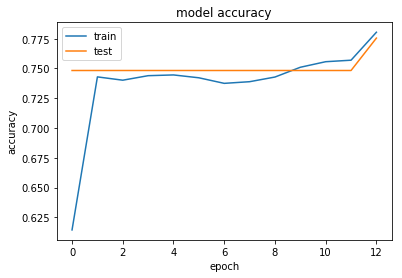

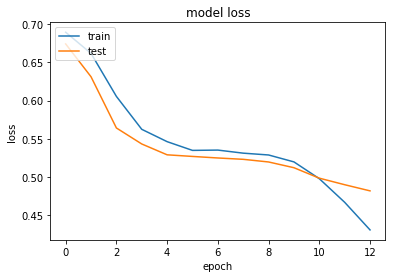

In [75]:
## Train the model 
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=13, validation_data=(val_X, val_y))
plotting(history)

In [111]:
loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

Test Accuracy: 75.153376


In [113]:
test_y

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

In [114]:
pred_test_y.shape

(978, 3)

In [77]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)

294/294 [==============================] - 0s 2ms/step


In [78]:
pred_val_y[pred_val_y>=0.5] = 1
pred_val_y[pred_val_y<0.5] = 0

In [80]:
# thresholds = []
# for thresh in np.arange(0.1, 0.501, 0.01):
#     thresh = np.round(thresh, 2)
#     res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
#     thresholds.append([thresh, res])
#     print("F1 score at threshold {0} is {1}".format(thresh, res))
    
# thresholds.sort(key=lambda x: x[1], reverse=True)
# best_thresh = thresholds[0][0]
# print("Best threshold: ", best_thresh)

In [97]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
# pred_test_y =  (pred_test_y > best_thresh).astype(int)



978/978 [==============================] - 1s 528us/step


In [99]:
pred_test_y.shape

(978, 3)

In [ ]:
pred_test_y[pred_test_y>=0.5] = 1
pred_test_y[pred_test_y<0.5] = 0

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

Sensitivity: 0.00%
Specificity: 100.00%


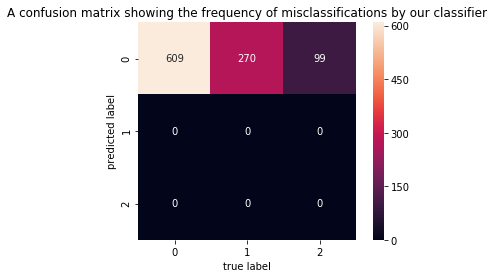

In [86]:
getConfusionMatrix(test_y.argmax(axis=1), pred_test_y.argmax(axis=1))

In [87]:
print("Accuracy:",metrics.accuracy_score(test_y.argmax(axis=1), pred_test_y.argmax(axis=1)))
print(classification_report(test_y, pred_test_y))

Accuracy: 0.6226993865030674
              precision    recall  f1-score   support

           0       0.68      0.89      0.77       609
           1       0.00      0.00      0.00       270
           2       0.00      0.00      0.00        99

   micro avg       0.68      0.55      0.61       978
   macro avg       0.23      0.30      0.26       978
weighted avg       0.42      0.55      0.48       978
 samples avg       0.55      0.55      0.55       978



/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted

## Using GloVe Embeddings

In [115]:
embed_size = 200

In [116]:
from numpy import asarray
# load the whole embedding into memory
embeddings_index = dict()
f = open('glove/glove.twitter.27B.200d.txt', encoding="utf8")
for line in f:
  values = line.split()
  word = values[0]
  coefs = asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

In [117]:
from numpy import zeros
# create a weight matrix for words in training docs
embedding_matrix = zeros((max_features, embed_size))
for word, i in tokenizer.word_index.items():
  if i >= max_features: continue
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [118]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(200, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dense(16, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 200)          10000000  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 400)          641600    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 400)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                6416      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 51        
Total para

In [119]:
#X_resampled, y_resampled = undersampleData(train_X, train_y)
X_resampled, y_resampled = train_X, train_y
#X_resampled, y_resampled = oversampleData(train_X, train_y)

Train on 2640 samples, validate on 294 samples
Epoch 1/13
2640/2640 [==============================] - 23s 9ms/step - loss: 0.5715 - acc: 0.6957 - val_loss: 0.5306 - val_acc: 0.7483
Epoch 2/13
2640/2640 [==============================] - 18s 7ms/step - loss: 0.5297 - acc: 0.7472 - val_loss: 0.4965 - val_acc: 0.7744
Epoch 3/13
2640/2640 [==============================] - 18s 7ms/step - loss: 0.4956 - acc: 0.7621 - val_loss: 0.4657 - val_acc: 0.7982
Epoch 4/13
2640/2640 [==============================] - 20s 8ms/step - loss: 0.4567 - acc: 0.8016 - val_loss: 0.4324 - val_acc: 0.8129
Epoch 5/13
2640/2640 [==============================] - 25s 10ms/step - loss: 0.4303 - acc: 0.8124 - val_loss: 0.4220 - val_acc: 0.8186
Epoch 6/13
2640/2640 [==============================] - 25s 10ms/step - loss: 0.4168 - acc: 0.8239 - val_loss: 0.4250 - val_acc: 0.8186
Epoch 7/13
2640/2640 [==============================] - 22s 8ms/step - loss: 0.4020 - acc: 0.8250 - val_loss: 0.4342 - val_acc: 0.8005
Epoch 

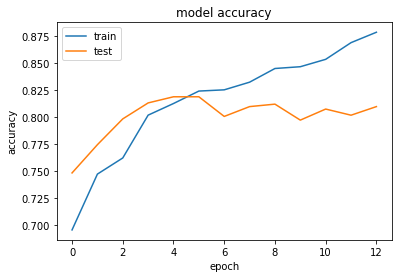

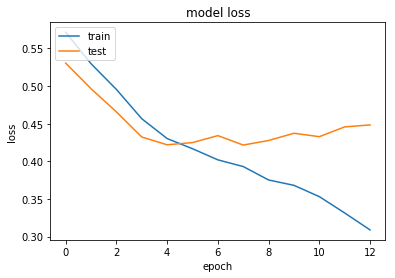

Test Accuracy: 81.935925


In [120]:
history = model.fit(X_resampled, y_resampled, batch_size=512, epochs=13, validation_data=(val_X, val_y))
plotting(history)

loss, acc = model.evaluate(test_X, test_y, verbose=0)
print('Test Accuracy: %f' % (acc*100))

In [121]:
# pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)


# thresholds = []
# for thresh in np.arange(0.1, 0.501, 0.01):
#     thresh = np.round(thresh, 2)
#     res = metrics.f1_score(val_y, (pred_val_y > thresh).astype(int))
#     thresholds.append([thresh, res])
#     print("F1 score at threshold {0} is {1}".format(thresh, res))
    
# thresholds.sort(key=lambda x: x[1], reverse=True)
# best_thresh = thresholds[0][0]
# print("Best threshold: ", best_thresh)


In [122]:
# pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
# pred_test_y = (pred_test_y > best_thresh).astype(int)

# unique, counts = np.unique(pred_test_y, return_counts=True)
# print(np.asarray((unique, counts)).T)

In [123]:
# getConfusionMatrix(test_y, pred_test_y)

In [125]:
pred_val_y = model.predict([val_X], batch_size=1024, verbose=1)

294/294 [==============================] - 1s 4ms/step


In [126]:
pred_val_y[pred_val_y>=0.5] = 1
pred_val_y[pred_val_y<0.5] = 0

In [127]:
pred_test_y = model.predict([test_X], batch_size=1024, verbose=1)
# pred_test_y =  (pred_test_y > best_thresh).astype(int)



978/978 [==============================] - 2s 2ms/step


In [128]:
pred_test_y[pred_test_y>=0.5] = 1
pred_test_y[pred_test_y<0.5] = 0

unique, counts = np.unique(pred_test_y, return_counts=True)
print(np.asarray((unique, counts)).T)

[[0.000e+00 2.058e+03]
 [1.000e+00 8.760e+02]]


Sensitivity: 44.81%
Specificity: 94.09%


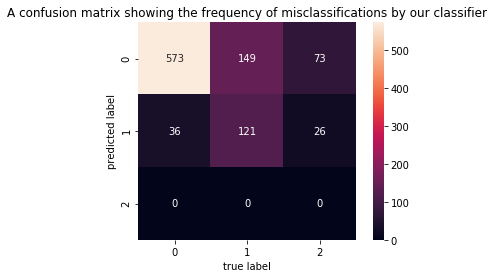

In [129]:
getConfusionMatrix(test_y.argmax(axis=1), pred_test_y.argmax(axis=1))

In [130]:
print("Accuracy:",metrics.accuracy_score(test_y.argmax(axis=1), pred_test_y.argmax(axis=1)))
print(classification_report(test_y, pred_test_y))

Accuracy: 0.7096114519427403
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       609
           1       0.66      0.45      0.53       270
           2       0.00      0.00      0.00        99

   micro avg       0.76      0.68      0.71       978
   macro avg       0.48      0.45      0.46       978
weighted avg       0.67      0.68      0.66       978
 samples avg       0.68      0.68      0.68       978



/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/nikhiloswal/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted